# Step 1A: Reproducible Doublet Detection 
This notebook performs doublet detection and singlet export.

In [1]:
%pip install -q scanpy scvi-tools pandas numpy scipy matplotlib leidenalg scikit-misc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: C:\Users\mmsid\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
from pathlib import Path
import os
import random
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / 'data').exists() and (ROOT.parent / 'data').exists():
    ROOT = ROOT.parent

NUMBA_CACHE = ROOT / '.numba_cache'
NUMBA_CACHE.mkdir(exist_ok=True)
os.environ['NUMBA_CACHE_DIR'] = str(NUMBA_CACHE)
os.environ['NUMBA_DISABLE_JIT'] = '1'

import scanpy as sc
from matplotlib import rc_context
import scvi
import torch

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
scvi.settings.seed = SEED
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RAW_FILE = ROOT / 'data/raw/Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5'
if not RAW_FILE.exists():
    raise FileNotFoundError(f'Missing raw matrix file: {RAW_FILE}')

OUT_SOLO_PRED_CSV = ROOT / 'results/single_cell/Human Breast Cancer_solo_predictions.csv'
OUT_SOLO_COUNT_CSV = ROOT / 'results/single_cell/Human Breast Cancer_solo_counts.csv'
OUT_SINGLET_H5AD = ROOT / 'data/processed/human_breast_cancer_singlets_pre_qc.h5ad'

C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


In [2]:
adata = sc.read_10x_h5(str(RAW_FILE))
adata.var_names_make_unique()

# Preprocessing before SCVI
sc.pp.filter_genes(adata, min_cells=10)
try:
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
except Exception:
    # Fallback for Windows Store Python cache edge cases
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat')

adata.layers['counts'] = adata.X.copy()
print('Prepared:', adata.n_obs, 'cells x', adata.n_vars, 'genes')

C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\anndata\_core\anndata.py:1825: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Prepared: 4898 cells x 2000 genes


In [3]:
# SCVI default model and SOLO default model
scvi.model.SCVI.setup_anndata(adata, layer='counts')
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightning\pytorch\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performa

Epoch 400/400: 100%|██████████| 400/400 [13:30<00:00,  2.14s/it, v_num=1, train_loss=1.24e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:30<00:00,  2.03s/it, v_num=1, train_loss=1.24e+3]


In [4]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightning\pytorch\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performa

Epoch 347/400:  87%|████████▋ | 347/400 [04:15<00:39,  1.36it/s, v_num=1, train_loss_step=0.305, train_loss_epoch=0.252] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.264. Signaling Trainer to stop.


In [5]:
# Hard prediction exactly as requested (soft=False)
solo_hard = pd.Series(solo.predict(soft=False), index=adata.obs_names, name='solo_label')
solo_hard = solo_hard.astype(str).str.lower().replace({
    '0': 'singlet', '1': 'doublet',
    'false': 'singlet', 'true': 'doublet'
})

adata.obs['solo_label'] = solo_hard.astype('category')

solo_df = pd.DataFrame({'barcode': adata.obs_names, 'solo_label': solo_hard.values})
solo_counts = solo_hard.value_counts(dropna=False).rename_axis('label').reset_index(name='count')

solo_df.to_csv(OUT_SOLO_PRED_CSV, index=False)
solo_counts.to_csv(OUT_SOLO_COUNT_CSV, index=False)

total_cells = int(adata.n_obs)
doublets = int((solo_hard == 'doublet').sum())
singlets = int((solo_hard == 'singlet').sum())

print('SOLO hard prediction counts:')
display(solo_counts)
print(f'Doublet rate: {doublets/total_cells:.2%} ({doublets}/{total_cells})')
print('Saved:', OUT_SOLO_PRED_CSV)
print('Saved:', OUT_SOLO_COUNT_CSV)

SOLO hard prediction counts:


C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\_contextlib.py:124: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabilities. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,label,count
0,singlet,4214
1,doublet,684


Doublet rate: 13.96% (684/4898)
Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\results\single_cell\Human Breast Cancer_solo_predictions.csv
Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\results\single_cell\Human Breast Cancer_solo_counts.csv


In [6]:
# Build prediction table and mapped labels
df = solo.predict()
df['prediction'] = solo.predict(soft=False)

# Align SOLO index to AnnData index (some SOLO outputs may have suffixes)
df.index = df.index.astype(str)
if not df.index.equals(adata.obs_names):
    df.index = df.index.str.replace(r'[-_]\d+$', '', regex=True)
df = df[~df.index.duplicated(keep='first')]
df = df.reindex(adata.obs_names)
df['prediction'] = df['prediction'].fillna('filtered')

doublet_d = dict(zip(df.index, df['prediction']))

def im_a_function(x):
    try:
        return doublet_d[x]
    except Exception:
        return 'filtered'

adata.obs['doublet'] = adata.obs.index.map(im_a_function)
adata.obs[['solo_label', 'doublet']].head()

C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\_contextlib.py:124: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabilities. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\mmsid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\_contextlib.py:124: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabilities. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,solo_label,doublet
AAACAACGAATAGTTC-1,doublet,doublet
AAACAAGTATCTCCCA-1,doublet,doublet
AAACAATCTACTAGCA-1,singlet,singlet
AAACACCAATAACTGC-1,singlet,singlet
AAACAGAGCGACTCCT-1,singlet,singlet


C:\Users\mmsid\AppData\Local\Temp\ipykernel_26288\458494713.py:24: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_vis, resolution=0.5)


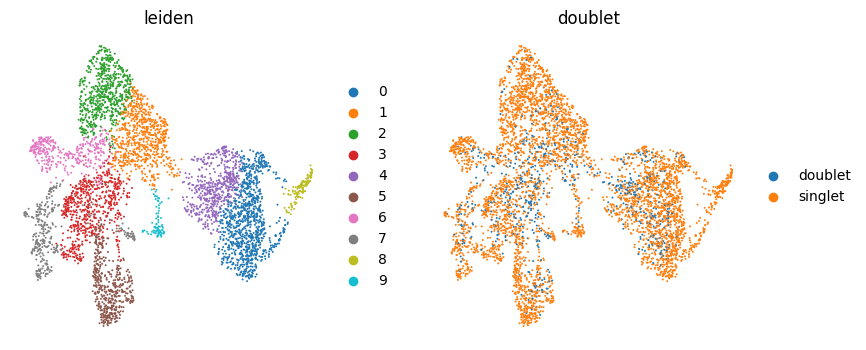

In [8]:
# Visualization
import numpy as np
from scipy.sparse import issparse
from matplotlib import rc_context
import scanpy as sc

adata_vis = adata.copy()

# manual CPM-like normalization to 1e4 per spot/cell
if issparse(adata_vis.X):
    counts = np.asarray(adata_vis.X.sum(axis=1)).ravel()
    counts[counts == 0] = 1.0
    scale = 1e4 / counts
    adata_vis.X = adata_vis.X.multiply(scale[:, None]).tocsr()
else:
    counts = adata_vis.X.sum(axis=1)
    counts[counts == 0] = 1.0
    adata_vis.X = adata_vis.X / counts[:, None] * 1e4

sc.pp.log1p(adata_vis)
sc.tl.pca(adata_vis, svd_solver="arpack")
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)
sc.tl.leiden(adata_vis, resolution=0.5)

label_col = "doublet" if "doublet" in adata_vis.obs.columns else "solo_label"
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata_vis, color=["leiden", label_col], size=8, frameon=False, show=True)


In [9]:
# Keep singlets and export (fixed + explicit)
label_col = "doublet" if "doublet" in adata.obs.columns else "solo_label"

adata_singlet = adata[adata.obs[label_col].astype(str).str.lower() == "singlet"].copy()
adata_singlet.write_h5ad(str(OUT_SINGLET_H5AD))

print("Label column used:", label_col)
print("Singlets retained:", adata_singlet.n_obs)
print("Saved:", OUT_SINGLET_H5AD)


Label column used: doublet
Singlets retained: 4214
Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\human_breast_cancer_singlets_pre_qc.h5ad


In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc

out_fig = ROOT / "figures/single_cell/Human Breast Cancer_solo_umap_leiden_doublet.png"
out_fig.parent.mkdir(parents=True, exist_ok=True)

sc.pl.umap(
    adata_vis,
    color=["leiden", "doublet"],
    size=8,
    frameon=False,
    show=False
)

plt.savefig(out_fig, dpi=300, bbox_inches="tight")
plt.close()

print("Saved:", out_fig)


Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\single_cell\Human Breast Cancer_solo_umap_leiden_doublet.png


In [11]:
out_pdf = ROOT / "figures/single_cell/Human Breast Cancer_solo_umap_leiden_doublet.pdf"
sc.pl.umap(adata_vis, color=["leiden", "doublet"], size=8, frameon=False, show=False)
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()
print("Saved:", out_pdf)


Saved: c:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\single_cell\Human Breast Cancer_solo_umap_leiden_doublet.pdf
